In [5]:
# DATA MANIPULATION
import numpy as np  
import pandas as pd 

# VISUALIZATION
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# MISC
import os
import cv2
import warnings
warnings.filterwarnings('ignore')
# import dicom to read the images
import pydicom as dicom
import tensorflow as tf
import math
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

ModuleNotFoundError: No module named 'cv'

In [2]:
! pip install cv2

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
df1 = pd.read_csv(r'C:\Users\madhu\Python-IITD\Pneumonia Detection Dataset\Dataset\Copy of stage_2_detailed_class_info.csv')

In [3]:
df1['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [4]:
# Remove multiple rows that are present for "Lung Opacity" class, probobaly because of multiple opacity boxes dimensions.
df1.drop_duplicates(inplace=True)

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26684 entries, 0 to 30225
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  26684 non-null  object
 1   class      26684 non-null  object
dtypes: object(2)
memory usage: 625.4+ KB


In [6]:
df1['class'].value_counts()

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

<AxesSubplot:xlabel='class', ylabel='count'>

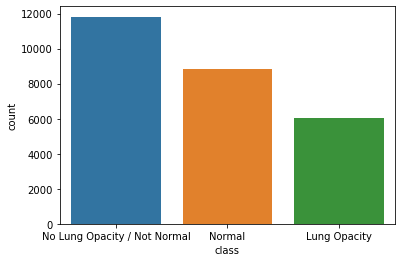

In [7]:
sns.countplot(df1['class'])

In [8]:
X = df1['patientId']
Y = df1['class']

In [9]:
# Split the dataset into 4 sets for easier loading and avoiding memory errors, maintaining the same 'class' ratios.
# The idea is we train the model on each set separately and at the end store the weights. Load the weights back before training the next set.
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, stratify = Y, test_size = 0.5, random_state =42)
x1, x2, y1, y2 = train_test_split(x_train, y_train, stratify = y_train, test_size = 0.5, random_state =42)
x3, x4, y3, y4 = train_test_split(x_val, y_val, stratify = y_val, test_size = 0.5, random_state =42)

In [10]:
print(x1.shape,y1.shape)
print(x2.shape,y2.shape)
print(x3.shape,y3.shape)
print(x4.shape,y4.shape)

(6671,) (6671,)
(6671,) (6671,)
(6671,) (6671,)
(6671,) (6671,)


In [11]:
y4.value_counts()

No Lung Opacity / Not Normal    2956
Normal                          2212
Lung Opacity                    1503
Name: class, dtype: int64

In [12]:
# Now we need to replace the x? datasets that has patiendId with their corresponding actual images/pixel data. 
# We do this by defining a function
def populate_X_images(x):
    os.chdir(r'C:\Users\madhu\Python-IITD\Pneumonia Detection Dataset\Dataset')
    file_path='stage_2_train_images'
    x_img = pd.DataFrame(columns=['image'])
    for Id in x:
        fname = str(Id) + ".dcm"
        ds = dicom.dcmread(os.path.join(file_path,fname))
        x_img = x_img.append({'image':ds.pixel_array},ignore_index=True)
    return x_img

In [13]:
# Define a new function to resize and reshape according to our needs
import cv2
def resize_reshape_x(x, shape: tuple):
    X_rsz = []
    for i in (x['image']):
        img = cv2.resize(i, shape)
        img = np.stack((img,)*3, axis=-1)
        X_rsz.append(img)
    return np.array(X_rsz)

In [14]:
del X
del Y

In [15]:
# Vizualizing the images
def plot_sample(x,y):
    plt.figure(figsize=(10,10))
    n=3
    j=1
    sample = [1,2000,6500]
    for i in sample:
        plt.subplot(1,n,j)
        plt.imshow(x[i])
        plt.title("{}".format(y.iloc[i]))
        j+=1

In [16]:
# pre-process data
def pre_process(x_tr, x_val, y_tr, y_val):
    x_tr = (x_tr/255).astype('float16')
    y_tr = pd.get_dummies(y_tr)
    x_val = (x_val/255).astype('float16')
    y_val = pd.get_dummies(y_val)
    return x_tr, x_val, y_tr, y_val

In [63]:
os.chdir(r'C:\Users\madhu\Python-IITD\Pneumonia Detection Dataset')
base_model = DenseNet121(weights=None,
                            include_top=False,
                            input_shape=(224,224,3), pooling="avg")

predictions = tf.keras.layers.Dense(14, activation='relu', name='predictions')(base_model.output)
base_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
base_model.load_weights("CheXNet_Keras_0.3.0_weights.h5")
#base_model.layers.pop(0)

print("CheXNet loaded")

CheXNet loaded


In [66]:
#base_model = DenseNet121(input_shape=(224,224,3),
                        # weights=r'C:\Users\madhu\Python-IITD\Pneumonia Detection Dataset\CheXNet_Keras_0.3.0_weights.h5',
#                         include_top=False,
#                         pooling='avg')

#for layer in base_model.layers[:-2]:
   # layer.trainable = False
base_model.trainable = True
base_model.summary()


custom_model = Sequential([
                        base_model,
                       # MaxPooling2D(),
                       # Flatten(),
                        Dropout(0.2),
                        #Dense(units=128, activation="relu"),
                        #Dropout(0.2),
                        Dense(units=3, activation='softmax')
                        ], name='custom_densenet_model')

custom_model.summary()
custom_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, 230, 230, 3)  0          ['input_18[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_34[0][0]']      
                                )                                                          

In [48]:
# function to plot Accuracy and loss plots
def plot_hist(tr_hist):
    accuracy = tr_hist.history['accuracy']
    val_accuracy = tr_hist.history['val_accuracy']
    loss = tr_hist.history['loss']
    val_loss = tr_hist.history['val_loss']
    epochs   = range(len(accuracy)) # Get number of epochs

    plt.plot  (epochs, accuracy, label = 'training accuracy')
    plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
    plt.title ('Training and validation accuracy')
    plt.legend(loc = 'lower right')
    plt.figure()

    plt.plot  (epochs, loss, label = 'training loss')
    plt.plot  (epochs, val_loss, label = 'validation loss')
    plt.legend(loc = 'upper right')
    plt.title ('Training and validation loss')

In [49]:
# Saving model and training history and its weights for future use
import pickle
def save_model_and_hist(model, hist, model_file, model_wght_file, hist_file):
    model.save(model_file)
    model.save_weights(model_wght_file)
    with open(hist_file, 'wb') as file_pi:
        pickle.dump(hist.history, file_pi)

In [50]:
def load_and_process(x, y):
    x_img = populate_X_images(x)
    print('Populated Images')
    x_img = resize_reshape_x(x_img,(224,224))
    print('Resized and reshaped the images')
    plot_sample(x_img, y)
    x_train, x_val, y_train, y_val = train_test_split(x_img, y, stratify = y, test_size = 0.2, random_state =42)
    x_train, x_val, y_train, y_val = pre_process(x_train, x_val, y_train, y_val)
    return x_train, x_val, y_train, y_val

In [67]:
def run_save_one_iteration(x, y, model, bsz, epo, modelname: str, j: int):
    x_train, x_val, y_train, y_val = load_and_process(x, y)
    print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)
    early = EarlyStopping(monitor='val_loss', patience = math.floor(epo*0.2),restore_best_weights=True)
    learn_rate_reduce = ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1,factor=0.3,min_lr=0.000001)
    model_fname = modelname + str(j) + "_epoch" + ".h5"
    model_check = ModelCheckpoint(model_fname,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 5,restore_best_weights=True)
    
    tr_history = model.fit(x=x_train, 
                           y=y_train, 
                           batch_size=bsz,
                           epochs=epo, 
                           validation_data=(x_val, y_val),
                           callbacks=[model_check, learn_rate_reduce, early],verbose=1)
    #plot_hist(tr_history)
    model_fname = modelname + str(j) + ".h5"
    model_wname = modelname + "_weights" + str(j) + ".h5"
    model_hname= modelname + "_hist" + str(j)
    save_model_and_hist(model, tr_history, model_fname, model_wname, model_hname)

In [52]:
# Load and return model
from tensorflow.keras.models import load_model
def load_and_return_model(modelname: str, j: int):
    model_fname = modelname + str(j) + ".h5"
    model = load_model(model_fname)
    return model

Populated Images
Resized and reshaped the images
(5336, 224, 224, 3) (5336, 3) (1335, 224, 224, 3) (1335, 3)
Epoch 1/20
167/167 [==============================] - ETA: 0s - loss: 1.0871 - accuracy: 0.4404 
Epoch 1: val_accuracy improved from -inf to 0.44270, saving model to densenet1_epoch.h5
167/167 [==============================] - 1883s 11s/step - loss: 1.0871 - accuracy: 0.4404 - val_loss: 1.0778 - val_accuracy: 0.4427 - lr: 0.0010
Epoch 2/20
167/167 [==============================] - ETA: 0s - loss: 1.0725 - accuracy: 0.4430 
Epoch 2: val_accuracy did not improve from 0.44270
167/167 [==============================] - 1859s 11s/step - loss: 1.0725 - accuracy: 0.4430 - val_loss: 1.0686 - val_accuracy: 0.4427 - lr: 0.0010
Epoch 3/20
167/167 [==============================] - ETA: 0s - loss: 1.0662 - accuracy: 0.4430 
Epoch 3: val_accuracy did not improve from 0.44270
167/167 [==============================] - 1817s 11s/step - loss: 1.0662 - accuracy: 0.4430 - val_loss: 1.0647 - val

KeyboardInterrupt: 

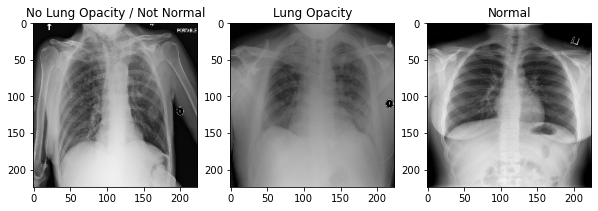

In [68]:
run_save_one_iteration(x1, y1, custom_model, 32, 20, 'densenet', 1)
model_densenet = load_and_return_model('densenet', 1)

In [53]:
# function to plot Accuracy and loss plots
def load_and_plot_hist(model_name: str, i):
    hist_fname = model_name + '_hist'+ str(i)
    with open(hist_fname, 'rb') as file_pi:
        tr_hist = pickle.load(file_pi)
    pd.DataFrame(tr_hist).plot()

In [ ]:
load_and_plot_hist('densenet',1)

In [ ]:
from tensorflow.keras.models import load_model
os.chdir(r'C:\Users\madhu\Python-IITD\Pneumonia Detection Dataset\Dataset')
model = load_model('resnet1_epoch.h5')


In [ ]:
    x_img = populate_X_images(x1)
    print('Populated Images')
    x_img = resize_reshape_x(x_img,(224,224))
    print('Resized and reshaped the images')
    plot_sample(x_img, y)

In [ ]:
    x_img = resize_reshape_x(x_img,(224,224))
    print('Resized and reshaped the images')
    plot_sample(x_img, y)

In [ ]:
 plot_sample(x_img, y1)

run_save_one_iteration(x2, y2, model, 32, 20, 'densenet', 2)
load_and_plot_hist('densenet',2)

from tensorflow.keras.models import load_model
os.chdir(r'C:\Users\madhu\Python-IITD\Pneumonia Detection Dataset\Dataset')
model = load_model('densenet2_epoch.h5')

run_save_one_iteration(x3, y3, model, 32, 20, 'densenet', 3)
load_and_plot_hist('densenet',3)

model = load_model('densenet3.h5')

run_save_one_iteration(x4, y4, model, 32, 20, 'densenet', 4)
load_and_plot_hist('densenet',4)